In [1]:
# DDPG, TD3, SAC, PPO

In [2]:
!nvidia-smi

Tue Sep 10 16:33:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off | 00000000:01:00.0  On |                  N/A |
|  0%   49C    P2              59W / 250W |    391MiB / 11264MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from beads_gym.environment.beads_cart_pole_environment import BeadsCartPoleEnvironment
from beads_gym.environment.beads_quad_copter_environment import BeadsQuadCopterEnvironment

In [4]:
import warnings ; warnings.filterwarnings('ignore')
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['OMP_NUM_THREADS'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from torch.distributions import Normal

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import count
import moviepy.editor as mpy

import os.path
import tempfile
import random
import base64
import glob
import time
import json
import gym
import io
import os
import gc

from gym import wrappers
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 300
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
SEEDS = (12, 34, 56) #, 78, 90)

%matplotlib inline

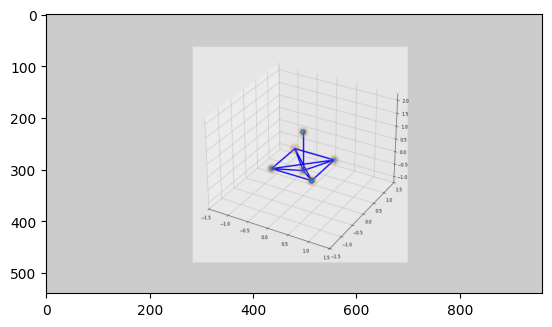

In [5]:
env = BeadsQuadCopterEnvironment()
env.reset()
plt.imshow(env.render())

In [6]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [7]:
torch.cuda.is_available()

True

In [8]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, seed=None, render=None, record=False,
                    unwrapped=False, monitor_mode=None, 
                    inner_wrappers=None, outer_wrappers=None):
        mdir = tempfile.mkdtemp()
        env = None
        if render:
            try:
                env = gym.make(env_name, render=render)
            except:
                pass
        if env_name == "BeadsCartPoleEnvironment":
            env = BeadsCartPoleEnvironment()
            env.do_render = render
            env.do_record = record
            env.monitor_mode = monitor_mode
            return env
        if env_name == "BeadsQuadCopterEnvironment":
            env = BeadsQuadCopterEnvironment()
            env.do_render = render
            env.do_record = record
            env.monitor_mode = monitor_mode
            return env
        if env is None:
            env = gym.make(env_name)
        if seed is not None: env.seed(seed)
        env = env.unwrapped if unwrapped else env
        if inner_wrappers:
            for wrapper in inner_wrappers:
                env = wrapper(env)
        env = wrappers.Monitor(
            env, mdir, force=True, 
            mode=monitor_mode, 
            video_callable=lambda e_idx: record) if monitor_mode else env
        if outer_wrappers:
            for wrapper in outer_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

In [9]:
def get_videos_html(env_videos, title, max_n_videos=4):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [10]:
def get_gif_html(video, title, video_id):
    video = np.array(video)
    num_frames = len(video)
    fps = 10

    # Create a VideoClip
    clip = mpy.VideoClip(
        # fun,
        lambda t: video[int(t * fps)],
        duration=num_frames / fps,
    )

    # Write the VideoClip to a file
    clip.write_videofile(f"{title}_{video_id}.mp4", fps=fps)

In [11]:
class RenderUint8(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def render(self, mode='rgb_array'):
        frame = self.env.render(mode=mode)
        return frame.astype(np.uint8)

# DDPG

In [12]:
class FCQV(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCQV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            in_dim = hidden_dims[i]
            if i == 0: 
                in_dim += output_dim
            hidden_layer = nn.Linear(in_dim, hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
    
    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, 
                             device=self.device, 
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state, action):
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(x))
        for i, hidden_layer in enumerate(self.hidden_layers):
            if i == 0:
                x = torch.cat((x, u), dim=1)
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [13]:
class FCDP(nn.Module):
    def __init__(self, 
                 input_dim,
                 action_bounds,
                 hidden_dims=(32,32), 
                 activation_fc=F.selu,
                 out_activation_fc=F.tanh):
        super(FCDP, self).__init__()
        self.activation_fc = activation_fc
        self.out_activation_fc = out_activation_fc
        self.act_min, self.act_max = action_bounds

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], len(self.act_max))

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
        self.act_min = torch.tensor(self.act_min,
                                    device=self.device, 
                                    dtype=torch.float32)

        self.act_max = torch.tensor(self.act_max,
                                    device=self.device, 
                                    dtype=torch.float32)
        
        self.nn_min = self.out_activation_fc(
            torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = self.out_activation_fc(
            torch.Tensor([float('inf')])).to(self.device)
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.act_max - self.act_min) / \
                                    (self.nn_max - self.nn_min) + self.act_min

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        x = self.out_activation_fc(x)
        return self.rescale_fn(x)

In [14]:
class ReplayBuffer():
    def __init__(self, 
                 max_size=10000, 
                 batch_size=64):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample):
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self):
        return self.size

In [15]:
class GreedyStrategy():
    def __init__(self, bounds):
        self.low, self.high = bounds
        self.ratio_noise_injected = 0

    def select_action(self, model, state):
        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        action = np.clip(greedy_action, self.low, self.high)
        return np.reshape(action, self.high.shape)

In [16]:
class NormalNoiseStrategy():
    def __init__(self, bounds, exploration_noise_ratio=0.1, exploration_noise_amplitude=None, ou_process=False):
        self.low, self.high = bounds
        
        if exploration_noise_ratio is None: assert exploration_noise_amplitude is not None
        if exploration_noise_amplitude is None: assert exploration_noise_ratio is not None
        self.exploration_noise_ratio = exploration_noise_ratio
        self.exploration_noise_amplitude = exploration_noise_amplitude
        self.ou_process = ou_process
        self.prev_noise = np.zeros(len(self.high))
        self.ratio_noise_injected = 0
        
    def select_action(self, model, state, max_exploration=False):
        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()
            
        noise = self.prev_noise if self.ou_process else np.zeros(len(self.high))
        if max_exploration:
            noise += np.random.normal(loc=0, scale=self.high, size=len(self.high))
        else:
            if self.exploration_noise_ratio is not None:
                noise += np.random.normal(loc=0, scale=1, size=len(self.high)) * np.abs(greedy_action) * self.exploration_noise_ratio
            elif self.exploration_noise_amplitude is not None:
                noise += np.random.normal(loc=0, scale=self.exploration_noise_amplitude, size=len(self.high))
            else:
                raise ValueError("No exploration noise specified")

        noisy_action = greedy_action + noise
        self.prev_noise = noise
        action = np.clip(noisy_action, self.low, self.high)
        
        self.ratio_noise_injected = np.mean(abs((greedy_action - action)/(self.high - self.low)))
        return action
    
    
class NormalNoiseDecayStrategy():
    def __init__(
        self,
        bounds,
        init_noise_ratio_mult=0.5, min_noise_ratio_mult=0.1,
        init_noise_ratio_add=0.5, min_noise_ratio_add=0.1,
        decay_steps=10000,
    ):
        self.t = 0
        self.low, self.high = bounds
        self.noise_ratio_mult = init_noise_ratio_mult
        self.init_noise_ratio_mult = init_noise_ratio_mult
        self.min_noise_ratio_mult = min_noise_ratio_mult
        self.noise_ratio_add = init_noise_ratio_add
        self.init_noise_ratio_add = init_noise_ratio_add
        self.min_noise_ratio_add = min_noise_ratio_add
        self.decay_steps = decay_steps
        self.ratio_noise_injected = 0

    def _noise_ratio_update(self):
        noise_ratio = 1 - self.t / self.decay_steps
        noise_ratio_mult = (self.init_noise_ratio_mult - self.min_noise_ratio_mult) * noise_ratio + self.min_noise_ratio_mult
        self.noise_ratio_mult = np.clip(noise_ratio_mult, self.min_noise_ratio_mult, self.init_noise_ratio_mult)
        noise_ratio_add = (self.init_noise_ratio_add - self.min_noise_ratio_add) * noise_ratio + self.min_noise_ratio_add
        self.noise_ratio_add = np.clip(noise_ratio_add, self.min_noise_ratio_add, self.init_noise_ratio_add)
        self.t += 1

    def select_action(self, model, state, max_exploration=False):
        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()
            
        noise = np.zeros(len(self.high))
        if max_exploration:
            noise += np.random.normal(loc=0, scale=self.high, size=len(self.high))
        else:
            mult_noise_scale = np.abs(greedy_action) * self.noise_ratio_mult
            noise += np.random.normal(loc=0, scale=mult_noise_scale, size=len(self.high))
            noise += np.random.normal(loc=0, scale=self.noise_ratio_add, size=len(self.high))

        noisy_action = greedy_action + noise
        action = np.clip(noisy_action, self.low, self.high)
        
        self._noise_ratio_update()
        
        self.ratio_noise_injected = np.mean(abs((greedy_action - action)/(self.high - self.low)))
        return action

In [17]:
class DDPG():
    def __init__(self, 
                 replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau):
        self.replay_buffer_fn = replay_buffer_fn

        self.policy_model_fn = policy_model_fn
        self.policy_max_grad_norm = policy_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        
        self.value_model_fn = value_model_fn
        self.value_max_grad_norm = value_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr

        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn

        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = tau

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences

        argmax_a_q_sp = self.target_policy_model(next_states)
        max_a_q_sp = self.target_value_model(next_states, argmax_a_q_sp)
        target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)
        q_sa = self.online_value_model(states, actions)
        td_error = q_sa - target_q_sa.detach()
        value_loss = td_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model.parameters(), 
                                       self.value_max_grad_norm)
        self.value_optimizer.step()

        argmax_a_q_s = self.online_policy_model(states)
        max_a_q_s = self.online_value_model(states, argmax_a_q_s)
        policy_loss = -max_a_q_s.mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_policy_model.parameters(), 
                                       self.policy_max_grad_norm)        
        self.policy_optimizer.step()

    def interaction_step(self, state, env, state_noise=None):
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        noisy_state = state if state_noise is None else state + state_noise
        action = self.training_strategy.select_action(self.online_policy_model, 
                                                      noisy_state, 
                                                      len(self.replay_buffer) < min_samples)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += self.training_strategy.ratio_noise_injected
        return new_state, is_terminal
    
    def update_networks(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model.parameters(), 
                                  self.online_value_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_policy_model.parameters(), 
                                  self.online_policy_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
        action_bounds = env.action_space.low, env.action_space.high
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_value_model = self.value_model_fn(nS, nA)
        self.online_value_model = self.value_model_fn(nS, nA)
        self.target_policy_model = self.policy_model_fn(nS, action_bounds)
        self.online_policy_model = self.policy_model_fn(nS, action_bounds)
        self.update_networks(tau=1.0)
        self.value_optimizer = self.value_optimizer_fn(self.online_value_model, 
                                                       self.value_optimizer_lr)        
        self.policy_optimizer = self.policy_optimizer_fn(self.online_policy_model, 
                                                         self.policy_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn(action_bounds)
        self.evaluation_strategy = evaluation_strategy_fn(action_bounds)
                    
        result = np.empty((max_episodes, 6))
        result[:] = np.nan
        training_time = 0
        state_noise_scale = 0.05
        reasonable_bound = 0.1
        how_often_within_reasonable_bounds = (np.linalg.norm(np.random.normal(loc=0, scale=state_noise_scale, size=(10000, 3)), axis=1) < reasonable_bound).mean()
        print(
            f"With the scale of {state_noise_scale:.2f}, the noise vector will be "
            f"{100 * how_often_within_reasonable_bounds:.2f}% of the time within a ball "
            f"of radius: {reasonable_bound}"
        )
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                if np.random.uniform() > 1.0:
                    state_noise = np.random.normal(loc=0, scale=state_noise_scale, size=len(state))
                else:
                    state_noise = None
                state, is_terminal = self.interaction_step(state, env, state_noise)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model.load(experiences)
                    self.optimize_model(experiences)

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_networks()

                if is_terminal:
                    gc.collect()
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_policy_model, env)
            self.save_checkpoint(episode-1, self.online_policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, mean_100_exp_rat, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = (
                f'el {elapsed_str}, ep {episode-1:04}, ts {total_step:07}, '
                f'mean_10_reward: {mean_10_reward:.2f}\u00B1{std_10_reward:.2f}, '
                f'mean_100_reward: {mean_100_reward:.2f}\u00B1{std_100_reward:.2f}, '
                f'mean_100_exp_rat: {mean_100_exp_rat:.2f}\u00B1{std_100_exp_rat:.2f}, '
                f'mean_100_eval_score: {mean_100_eval_score:.2f}\u00B1{std_100_eval_score:.2f}'
            )
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}min training time,'
              ' {:.2f}min wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time / 60, wallclock_time / 60))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if eval_env.do_render: eval_env.render()
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2):

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        for i in range(n_episodes):
            env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)
            self.evaluate(self.online_policy_model, env, n_episodes=1)
            env.close()
            data = get_gif_html(env.videos[0], 
                                title.format(self.__class__.__name__),
                                i)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=4):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.online_policy_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [18]:
ddpg_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        # 'env_name': 'BeadsCartPole',
        'env_name': 'BeadsQuadCopterEnvironment',
        'gamma': 0.99, # 0.99,
        'max_minutes': 300,
        'max_episodes': 2000,
        'goal_mean_100_reward': 140000.0,
    }

    policy_model_fn = lambda nS, bounds: FCDP(nS, bounds, hidden_dims=(300,300))
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003

    value_model_fn = lambda nS, nA: FCQV(nS, nA, hidden_dims=(300,300))
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0003

    # training_strategy_fn = lambda bounds: NormalNoiseStrategy(bounds, exploration_noise_ratio=0.1, exploration_noise_amplitude=1.0)
    training_strategy_fn = lambda bounds: NormalNoiseDecayStrategy(bounds,
                                                                   init_noise_ratio_mult=0.1,
                                                                   min_noise_ratio_mult=0.01,
                                                                   init_noise_ratio_add=1.5,
                                                                   min_noise_ratio_add=0.01,
                                                                   decay_steps=2_000_000)
    # training_strategy_fn = lambda bounds: NormalNoiseStrategy(
    #     bounds,
    #     exploration_noise_ratio=0.1,
    #     exploration_noise_amplitude=0.2,
    #     ou_process=True,    
    # )
    evaluation_strategy_fn = lambda bounds: GreedyStrategy(bounds)

    replay_buffer_fn = lambda: ReplayBuffer(max_size=1_000_000, batch_size=256)
    n_warmup_batches = 5
    update_target_every_steps = 2
    tau = 0.005
    
    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()

    agent = DDPG(replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    ddpg_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        print('best_agent assigned!\n')
        best_agent = agent
        
ddpg_results = np.array(ddpg_results)
_ = BEEP()

del best_agent.replay_buffer
print(gc.collect())

With the scale of 0.05, the noise vector will be 74.20% of the time within a ball of radius: 0.1
el 00:00:01, ep 0000, ts 0000190, mean_10_reward: 47.75±0.00, mean_100_reward: 47.75±0.00, mean_100_exp_rat: 0.34±0.00, mean_100_eval_score: -15.42±0.00
el 00:05:01, ep 0282, ts 0041569, mean_10_reward: 376.70±94.76, mean_100_reward: 181.21±276.79, mean_100_exp_rat: 0.08±0.00, mean_100_eval_score: 100.53±307.38
el 00:10:04, ep 0423, ts 0080942, mean_10_reward: 71.61±997.71, mean_100_reward: 403.74±487.21, mean_100_exp_rat: 0.08±0.00, mean_100_eval_score: 192.46±536.97
el 00:15:05, ep 0543, ts 0117403, mean_10_reward: 419.17±450.10, mean_100_reward: 608.12±394.12, mean_100_exp_rat: 0.08±0.00, mean_100_eval_score: 489.79±352.65
el 00:20:07, ep 0662, ts 0153867, mean_10_reward: 1115.34±390.20, mean_100_reward: 813.52±237.45, mean_100_exp_rat: 0.08±0.00, mean_100_eval_score: 629.42±250.81
el 00:25:07, ep 0740, ts 0189260, mean_10_reward: 724.42±292.27, mean_100_reward: 1007.09±484.07, mean_100_

In [ ]:
ddpg_max_t, ddpg_max_r, ddpg_max_s, ddpg_max_exp, \
ddpg_max_sec, ddpg_max_rt = np.max(ddpg_results, axis=0).T
ddpg_min_t, ddpg_min_r, ddpg_min_s, ddpg_min_exp, \
ddpg_min_sec, ddpg_min_rt = np.min(ddpg_results, axis=0).T
ddpg_mean_t, ddpg_mean_r, ddpg_mean_s, ddpg_mean_exp, \
ddpg_mean_sec, ddpg_mean_rt = np.mean(ddpg_results, axis=0).T
ddpg_x = np.arange(len(ddpg_mean_s))

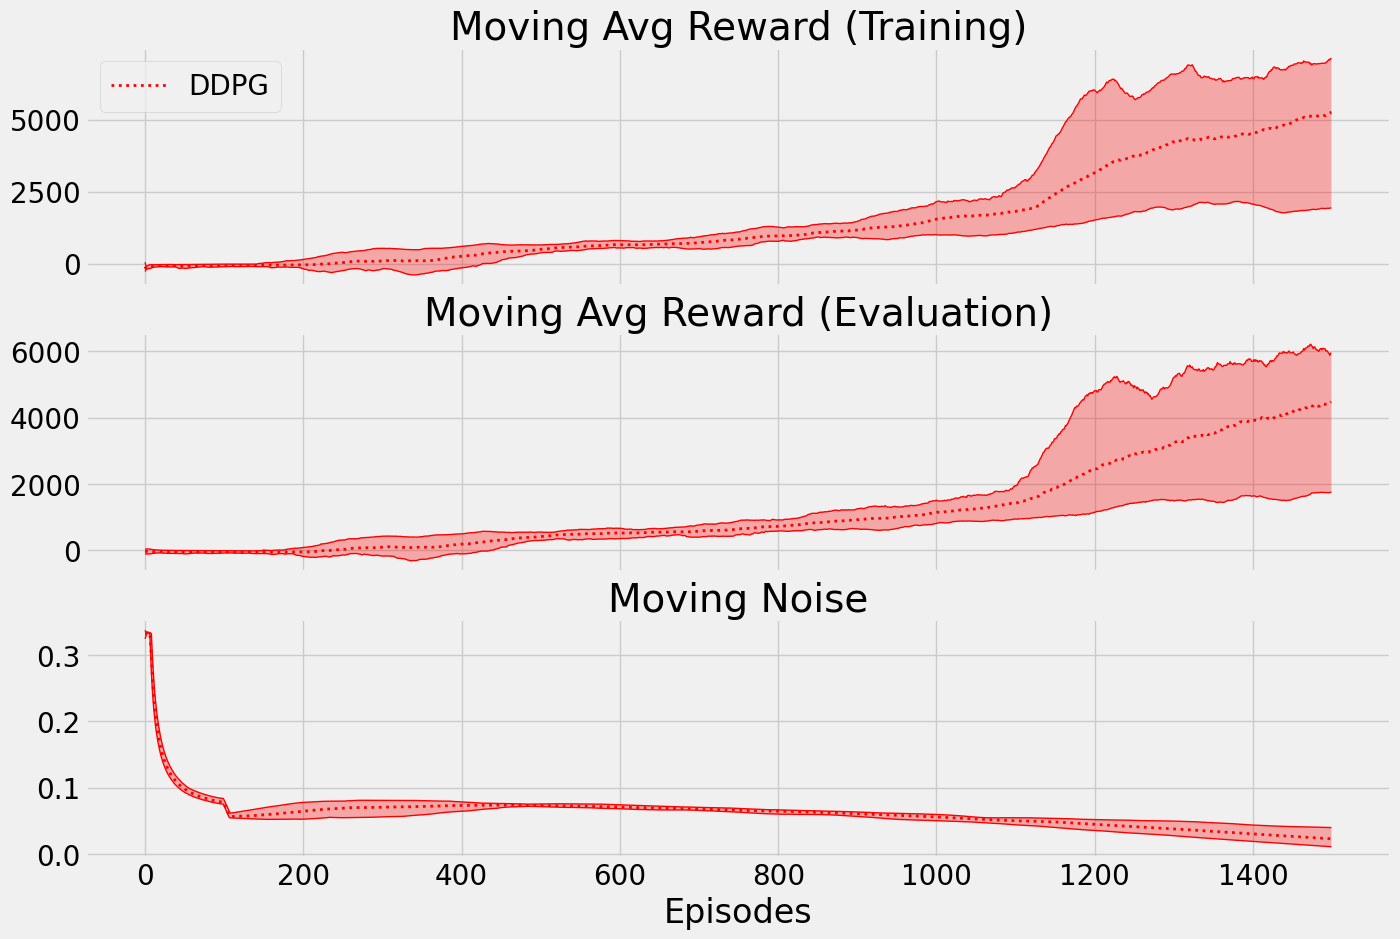

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15,10), sharey=False, sharex=True)

# DDPG
axs[0].plot(ddpg_max_r, 'r', linewidth=1)
axs[0].plot(ddpg_min_r, 'r', linewidth=1)
axs[0].plot(ddpg_mean_r, 'r:', label='DDPG', linewidth=2)
axs[0].fill_between(
    ddpg_x, ddpg_min_r, ddpg_max_r, facecolor='r', alpha=0.3)

axs[1].plot(ddpg_max_s, 'r', linewidth=1)
axs[1].plot(ddpg_min_s, 'r', linewidth=1)
axs[1].plot(ddpg_mean_s, 'r:', label='DDPG', linewidth=2)
axs[1].fill_between(
    ddpg_x, ddpg_min_s, ddpg_max_s, facecolor='r', alpha=0.3)

axs[2].plot(ddpg_max_exp, 'r', linewidth=1)
axs[2].plot(ddpg_min_exp, 'r', linewidth=1)
axs[2].plot(ddpg_mean_exp, 'r:', label='DDPG', linewidth=2)
axs[2].fill_between(
    ddpg_x, ddpg_min_exp, ddpg_max_exp, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Moving Noise')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.savefig("progress.png")

In [ ]:
del ddpg_results
print(gc.collect())

120


In [ ]:
best_agent.demo_last(title="last")
print('done')
# best_agent.demo_progression(title="progress")

Moviepy - Building video last_0.mp4.
Moviepy - Writing video last_0.mp4



Moviepy - Done !
Moviepy - video ready last_0.mp4
Moviepy - Building video last_1.mp4.
Moviepy - Writing video last_1.mp4



Moviepy - Done !
Moviepy - video ready last_1.mp4
done


<Figure size 1500x800 with 0 Axes>

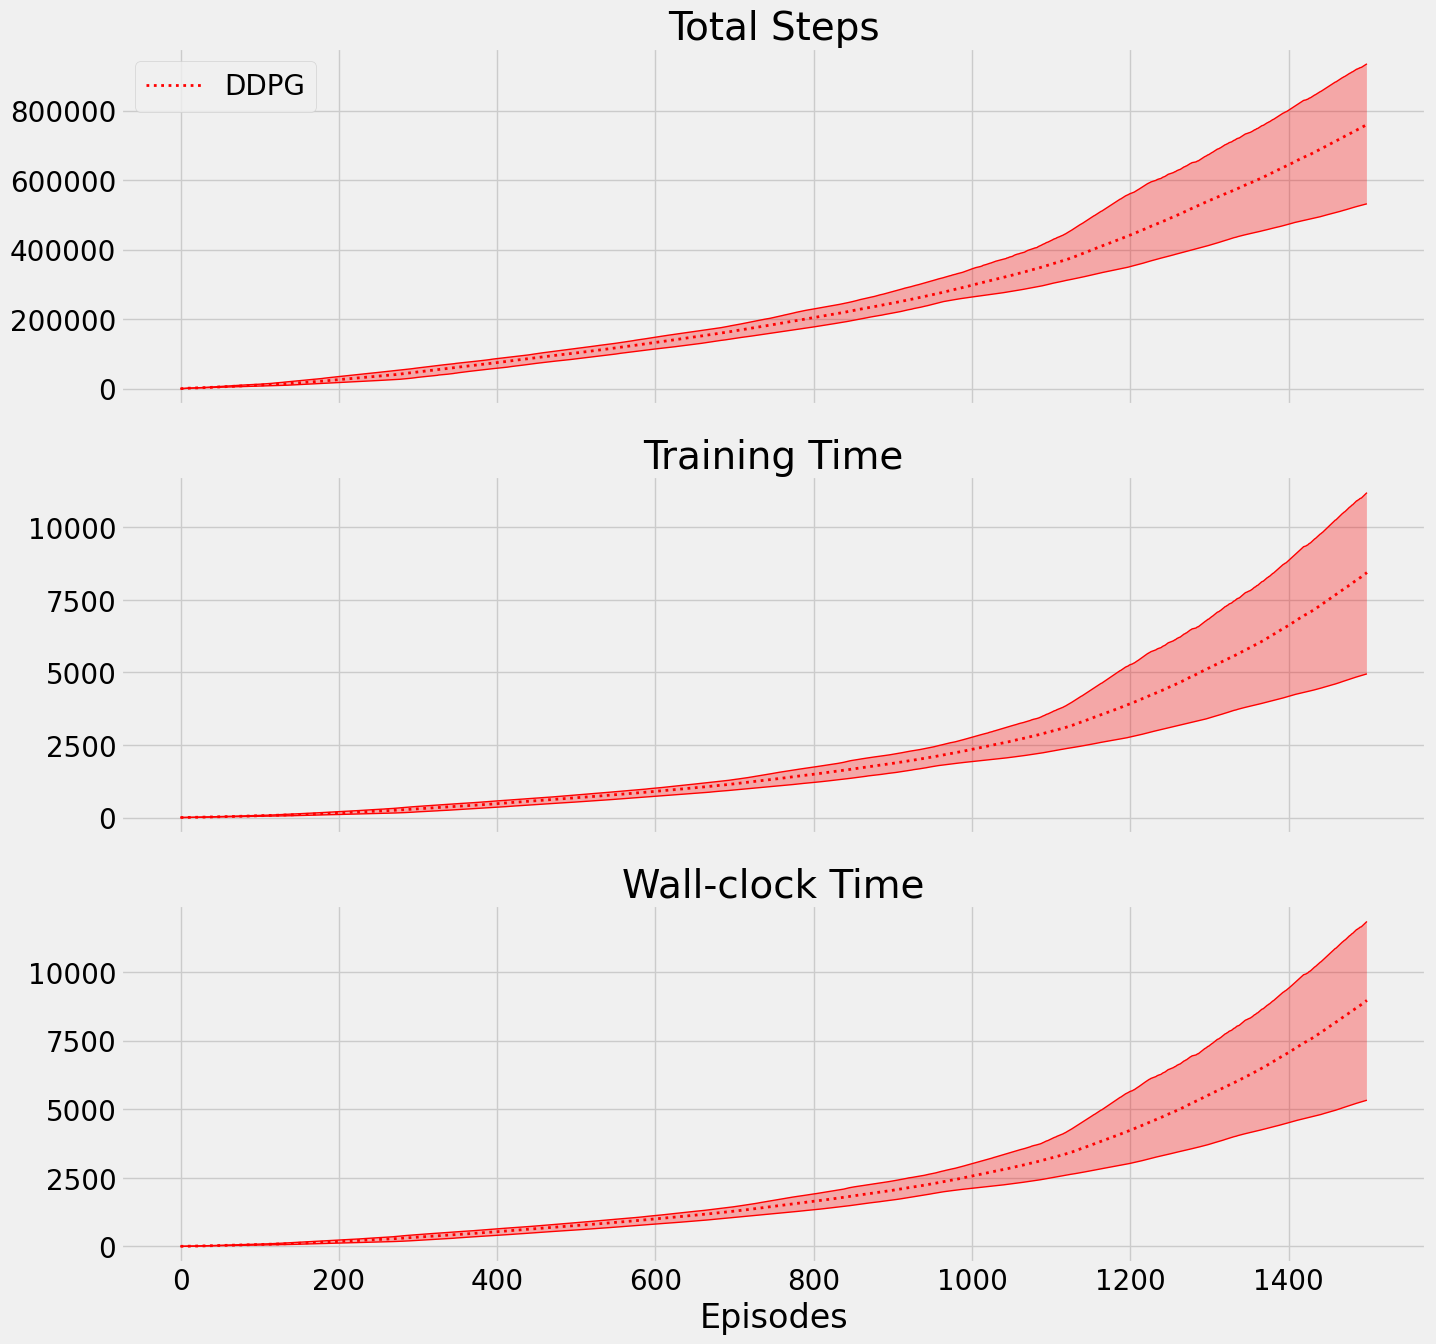

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharey=False, sharex=True)

# DDPG
axs[0].plot(ddpg_max_t, 'r', linewidth=1)
axs[0].plot(ddpg_min_t, 'r', linewidth=1)
axs[0].plot(ddpg_mean_t, 'r:', label='DDPG', linewidth=2)
axs[0].fill_between(
    ddpg_x, ddpg_min_t, ddpg_max_t, facecolor='r', alpha=0.3)

axs[1].plot(ddpg_max_sec, 'r', linewidth=1)
axs[1].plot(ddpg_min_sec, 'r', linewidth=1)
axs[1].plot(ddpg_mean_sec, 'r:', label='DDPG', linewidth=2)
axs[1].fill_between(
    ddpg_x, ddpg_min_sec, ddpg_max_sec, facecolor='r', alpha=0.3)

axs[2].plot(ddpg_max_rt, 'r', linewidth=1)
axs[2].plot(ddpg_min_rt, 'r', linewidth=1)
axs[2].plot(ddpg_mean_rt, 'r:', label='DDPG', linewidth=2)
axs[2].fill_between(
    ddpg_x, ddpg_min_rt, ddpg_max_rt, facecolor='r', alpha=0.3)

# ALL
axs[0].set_title('Total Steps')
axs[1].set_title('Training Time')
axs[2].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [ ]:
ddpg_root_dir = os.path.join(RESULTS_DIR, 'ddpg')
not os.path.exists(ddpg_root_dir) and os.makedirs(ddpg_root_dir)

np.save(os.path.join(ddpg_root_dir, 'x'), ddpg_x)

np.save(os.path.join(ddpg_root_dir, 'max_r'), ddpg_max_r)
np.save(os.path.join(ddpg_root_dir, 'min_r'), ddpg_min_r)
np.save(os.path.join(ddpg_root_dir, 'mean_r'), ddpg_mean_r)

np.save(os.path.join(ddpg_root_dir, 'max_s'), ddpg_max_s)
np.save(os.path.join(ddpg_root_dir, 'min_s'), ddpg_min_s )
np.save(os.path.join(ddpg_root_dir, 'mean_s'), ddpg_mean_s)

np.save(os.path.join(ddpg_root_dir, 'max_t'), ddpg_max_t)
np.save(os.path.join(ddpg_root_dir, 'min_t'), ddpg_min_t)
np.save(os.path.join(ddpg_root_dir, 'mean_t'), ddpg_mean_t)

np.save(os.path.join(ddpg_root_dir, 'max_sec'), ddpg_max_sec)
np.save(os.path.join(ddpg_root_dir, 'min_sec'), ddpg_min_sec)
np.save(os.path.join(ddpg_root_dir, 'mean_sec'), ddpg_mean_sec)

np.save(os.path.join(ddpg_root_dir, 'max_rt'), ddpg_max_rt)
np.save(os.path.join(ddpg_root_dir, 'min_rt'), ddpg_min_rt)
np.save(os.path.join(ddpg_root_dir, 'mean_rt'), ddpg_mean_rt)

# TD3

In [ ]:
class NormalNoiseDecayStrategy():
    def __init__(self, bounds, init_noise_ratio=0.5, min_noise_ratio=0.1, decay_steps=10000):
        self.t = 0
        self.low, self.high = bounds
        self.noise_ratio = init_noise_ratio
        self.init_noise_ratio = init_noise_ratio
        self.min_noise_ratio = min_noise_ratio
        self.decay_steps = decay_steps
        self.ratio_noise_injected = 0

    def _noise_ratio_update(self):
        noise_ratio = 1 - self.t / self.decay_steps
        noise_ratio = (self.init_noise_ratio - self.min_noise_ratio) * noise_ratio + self.min_noise_ratio
        noise_ratio = np.clip(noise_ratio, self.min_noise_ratio, self.init_noise_ratio)
        self.t += 1
        return noise_ratio

    def select_action(self, model, state, max_exploration=False):
        if max_exploration:
            noise_scale = self.high
        else:
            noise_scale = self.noise_ratio * self.high

        with torch.no_grad():
            greedy_action = model(state).cpu().detach().data.numpy().squeeze()

        noise = np.random.normal(loc=0, scale=noise_scale, size=len(self.high))
        noisy_action = greedy_action + noise
        action = np.clip(noisy_action, self.low, self.high)

        self.noise_ratio = self._noise_ratio_update()
        self.ratio_noise_injected = np.mean(abs((greedy_action - action)/(self.high - self.low)))
        return action

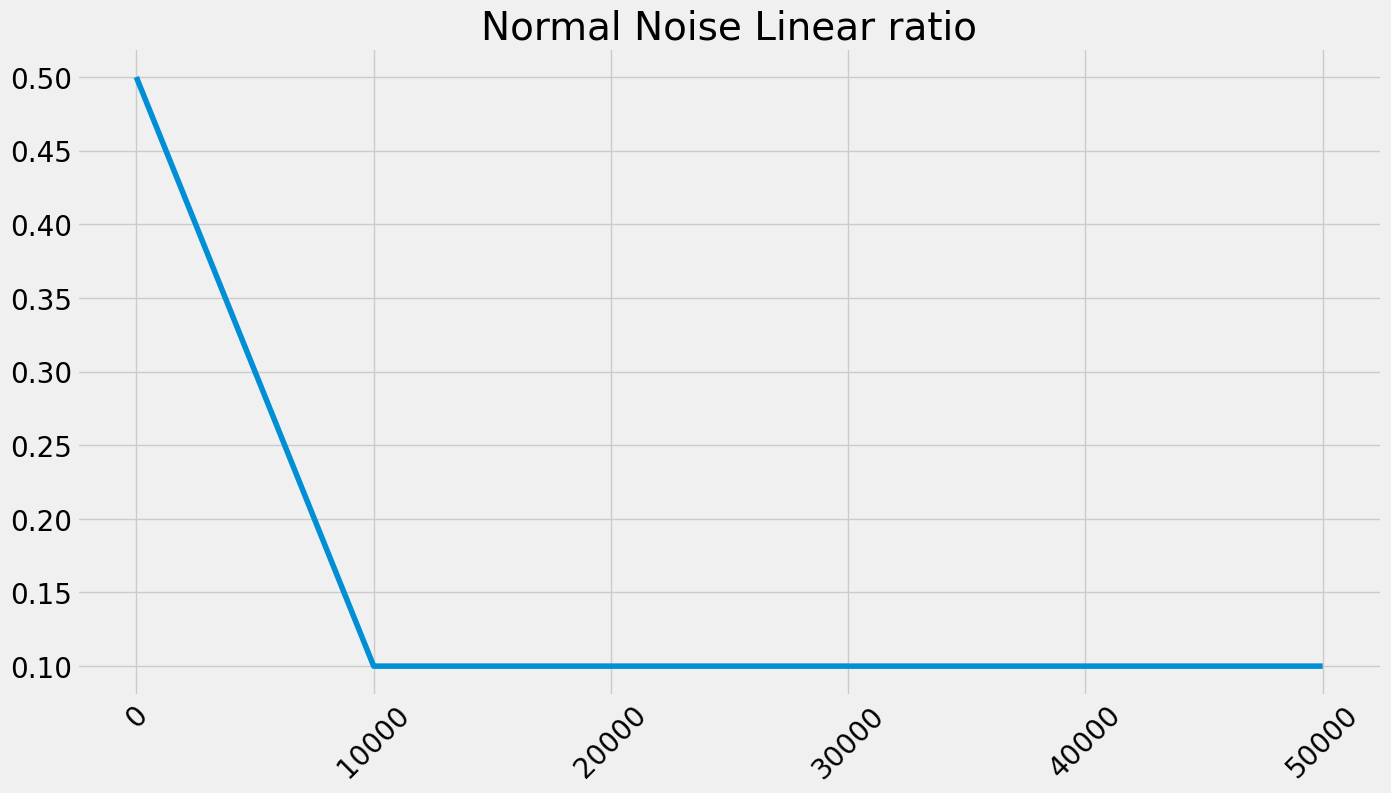

In [ ]:
s = NormalNoiseDecayStrategy(([-2],[2]))
plt.plot([s._noise_ratio_update() for _ in range(50000)])
plt.title('Normal Noise Linear ratio')
plt.xticks(rotation=45)
plt.show()

In [ ]:
class FCTQV(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCTQV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer_a = nn.Linear(input_dim + output_dim, hidden_dims[0])
        self.input_layer_b = nn.Linear(input_dim + output_dim, hidden_dims[0])

        self.hidden_layers_a = nn.ModuleList()
        self.hidden_layers_b = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer_a = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers_a.append(hidden_layer_a)

            hidden_layer_b = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers_b.append(hidden_layer_b)

        self.output_layer_a = nn.Linear(hidden_dims[-1], 1)
        self.output_layer_b = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, 
                             device=self.device, 
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state, action):
        x, u = self._format(state, action)
        x = torch.cat((x, u), dim=1)
        xa = self.activation_fc(self.input_layer_a(x))
        xb = self.activation_fc(self.input_layer_b(x))
        for hidden_layer_a, hidden_layer_b in zip(self.hidden_layers_a, self.hidden_layers_b):
            xa = self.activation_fc(hidden_layer_a(xa))
            xb = self.activation_fc(hidden_layer_b(xb))
        xa = self.output_layer_a(xa)
        xb = self.output_layer_b(xb)
        return xa, xb
    
    def Qa(self, state, action):
        x, u = self._format(state, action)
        x = torch.cat((x, u), dim=1)
        xa = self.activation_fc(self.input_layer_a(x))
        for hidden_layer_a in self.hidden_layers_a:
            xa = self.activation_fc(hidden_layer_a(xa))
        return self.output_layer_a(xa)
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [ ]:
class TD3():
    def __init__(self, 
                 replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn, 
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr, 
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_value_target_every_steps,
                 update_policy_target_every_steps,
                 train_policy_every_steps,
                 tau,
                 policy_noise_ratio,
                 policy_noise_clip_ratio):
        self.replay_buffer_fn = replay_buffer_fn

        self.policy_model_fn = policy_model_fn
        self.policy_max_grad_norm = policy_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        
        self.value_model_fn = value_model_fn
        self.value_max_grad_norm = value_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr

        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn

        self.n_warmup_batches = n_warmup_batches
        self.update_value_target_every_steps = update_value_target_every_steps
        self.update_policy_target_every_steps = update_policy_target_every_steps
        self.train_policy_every_steps = train_policy_every_steps
        
        self.tau = tau
        self.policy_noise_ratio = policy_noise_ratio
        self.policy_noise_clip_ratio = policy_noise_clip_ratio

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        with torch.no_grad():
            a_ran = self.target_policy_model.env_max - self.target_policy_model.env_min
            a_noise = torch.randn_like(actions) * self.policy_noise_ratio * a_ran
            n_min = self.target_policy_model.env_min * self.policy_noise_clip_ratio
            n_max = self.target_policy_model.env_max * self.policy_noise_clip_ratio            
            a_noise = torch.max(torch.min(a_noise, n_max), n_min)

            argmax_a_q_sp = self.target_policy_model(next_states)
            noisy_argmax_a_q_sp = argmax_a_q_sp + a_noise
            noisy_argmax_a_q_sp = torch.max(torch.min(noisy_argmax_a_q_sp, 
                                                      self.target_policy_model.env_max),
                                            self.target_policy_model.env_min)

            max_a_q_sp_a, max_a_q_sp_b = self.target_value_model(next_states, noisy_argmax_a_q_sp)
            max_a_q_sp = torch.min(max_a_q_sp_a, max_a_q_sp_b)

            target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)

        q_sa_a, q_sa_b = self.online_value_model(states, actions)
        td_error_a = q_sa_a - target_q_sa
        td_error_b = q_sa_b - target_q_sa

        value_loss = td_error_a.pow(2).mul(0.5).mean() + td_error_b.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model.parameters(), 
                                       self.value_max_grad_norm)
        self.value_optimizer.step()

        if np.sum(self.episode_timestep) % self.train_policy_every_steps == 0:
            argmax_a_q_s = self.online_policy_model(states)
            max_a_q_s = self.online_value_model.Qa(states, argmax_a_q_s)

            policy_loss = -max_a_q_s.mean()
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.online_policy_model.parameters(), 
                                           self.policy_max_grad_norm)        
            self.policy_optimizer.step()

    def interaction_step(self, state, env):
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        action = self.training_strategy.select_action(self.online_policy_model, 
                                                      state, 
                                                      len(self.replay_buffer) < min_samples)
        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += self.training_strategy.ratio_noise_injected
        return new_state, is_terminal

    def update_value_network(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model.parameters(), 
                                  self.online_value_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def update_policy_network(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_policy_model.parameters(), 
                                  self.online_policy_model.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
        action_bounds = env.action_space.low, env.action_space.high
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.target_value_model = self.value_model_fn(nS, nA)
        self.online_value_model = self.value_model_fn(nS, nA)
        self.update_value_network(tau=1.0)

        self.target_policy_model = self.policy_model_fn(nS, action_bounds)
        self.online_policy_model = self.policy_model_fn(nS, action_bounds)
        self.update_policy_network(tau=1.0)

        self.value_optimizer = self.value_optimizer_fn(self.online_value_model, 
                                                       self.value_optimizer_lr)        
        self.policy_optimizer = self.policy_optimizer_fn(self.online_policy_model, 
                                                         self.policy_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = training_strategy_fn(action_bounds)
        self.evaluation_strategy = evaluation_strategy_fn(action_bounds)
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model.load(experiences)
                    self.optimize_model(experiences)

                if np.sum(self.episode_timestep) % self.update_value_target_every_steps == 0:
                    self.update_value_network()

                if np.sum(self.episode_timestep) % self.update_policy_target_every_steps == 0:
                    self.update_policy_network()

                if is_terminal:
                    gc.collect()
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_policy_model, env)
            self.save_checkpoint(episode-1, self.online_policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.online_policy_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=4):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.online_policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.online_policy_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [ ]:
td3_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'HopperBulletEnv-v0',
        'gamma': 0.99,
        'max_minutes': 300,
        'max_episodes': 10000,
        'goal_mean_100_reward': 1500
    }
    
    policy_model_fn = lambda nS, bounds: FCDP(nS, bounds, hidden_dims=(256,256))
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003

    value_model_fn = lambda nS, nA: FCTQV(nS, nA, hidden_dims=(256,256))
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0003

    training_strategy_fn = lambda bounds: NormalNoiseDecayStrategy(bounds,
                                                                   init_noise_ratio=0.5,
                                                                   min_noise_ratio=0.1,
                                                                   decay_steps=200000)
    evaluation_strategy_fn = lambda bounds: GreedyStrategy(bounds)

    replay_buffer_fn = lambda: ReplayBuffer(max_size=1000000, batch_size=256)
    n_warmup_batches = 5
    update_value_target_every_steps = 2
    update_policy_target_every_steps = 2
    train_policy_every_steps = 2
    policy_noise_ratio = 0.1
    policy_noise_clip_ratio = 0.5
    tau = 0.01

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()

    agent = TD3(replay_buffer_fn,
                policy_model_fn, 
                policy_max_grad_norm, 
                policy_optimizer_fn, 
                policy_optimizer_lr,
                value_model_fn,
                value_max_grad_norm, 
                value_optimizer_fn, 
                value_optimizer_lr, 
                training_strategy_fn,
                evaluation_strategy_fn,
                n_warmup_batches,
                update_value_target_every_steps,
                update_policy_target_every_steps,
                train_policy_every_steps,
                tau,
                policy_noise_ratio,
                policy_noise_clip_ratio)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, inner_wrappers=[RenderUint8])
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    td3_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
td3_results = np.array(td3_results)
_ = BEEP()

NameNotFound: Environment HopperBulletEnv doesn't exist. 

In [ ]:
best_agent.demo_progression()

In [ ]:
best_agent.demo_last()

In [ ]:
td3_max_t, td3_max_r, td3_max_s, \
td3_max_sec, td3_max_rt = np.max(td3_results, axis=0).T
td3_min_t, td3_min_r, td3_min_s, \
td3_min_sec, td3_min_rt = np.min(td3_results, axis=0).T
td3_mean_t, td3_mean_r, td3_mean_s, \
td3_mean_sec, td3_mean_rt = np.mean(td3_results, axis=0).T
td3_x = np.arange(len(td3_mean_s))

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# TD3
axs[0].plot(td3_max_r, 'b', linewidth=1)
axs[0].plot(td3_min_r, 'b', linewidth=1)
axs[0].plot(td3_mean_r, 'b:', label='TD3', linewidth=2)
axs[0].fill_between(
    td3_x, td3_min_r, td3_max_r, facecolor='b', alpha=0.3)

axs[1].plot(td3_max_s, 'b', linewidth=1)
axs[1].plot(td3_min_s, 'b', linewidth=1)
axs[1].plot(td3_mean_s, 'b:', label='TD3', linewidth=2)
axs[1].fill_between(
    td3_x, td3_min_s, td3_max_s, facecolor='b', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharey=False, sharex=True)

# TD3
axs[0].plot(td3_max_t, 'b', linewidth=1)
axs[0].plot(td3_min_t, 'b', linewidth=1)
axs[0].plot(td3_mean_t, 'b:', label='TD3', linewidth=2)
axs[0].fill_between(
    td3_x, td3_min_t, td3_max_t, facecolor='b', alpha=0.3)

axs[1].plot(td3_max_sec, 'b', linewidth=1)
axs[1].plot(td3_min_sec, 'b', linewidth=1)
axs[1].plot(td3_mean_sec, 'b:', label='TD3', linewidth=2)
axs[1].fill_between(
    td3_x, td3_min_sec, td3_max_sec, facecolor='b', alpha=0.3)

axs[2].plot(td3_max_rt, 'b', linewidth=1)
axs[2].plot(td3_min_rt, 'b', linewidth=1)
axs[2].plot(td3_mean_rt, 'b:', label='TD3', linewidth=2)
axs[2].fill_between(
    td3_x, td3_min_rt, td3_max_rt, facecolor='b', alpha=0.3)

# ALL
axs[0].set_title('Total Steps')
axs[1].set_title('Training Time')
axs[2].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [ ]:
td3_root_dir = os.path.join(RESULTS_DIR, 'td3')
not os.path.exists(td3_root_dir) and os.makedirs(td3_root_dir)

np.save(os.path.join(td3_root_dir, 'x'), td3_x)

np.save(os.path.join(td3_root_dir, 'max_r'), td3_max_r)
np.save(os.path.join(td3_root_dir, 'min_r'), td3_min_r)
np.save(os.path.join(td3_root_dir, 'mean_r'), td3_mean_r)

np.save(os.path.join(td3_root_dir, 'max_s'), td3_max_s)
np.save(os.path.join(td3_root_dir, 'min_s'), td3_min_s )
np.save(os.path.join(td3_root_dir, 'mean_s'), td3_mean_s)

np.save(os.path.join(td3_root_dir, 'max_t'), td3_max_t)
np.save(os.path.join(td3_root_dir, 'min_t'), td3_min_t)
np.save(os.path.join(td3_root_dir, 'mean_t'), td3_mean_t)

np.save(os.path.join(td3_root_dir, 'max_sec'), td3_max_sec)
np.save(os.path.join(td3_root_dir, 'min_sec'), td3_min_sec)
np.save(os.path.join(td3_root_dir, 'mean_sec'), td3_mean_sec)

np.save(os.path.join(td3_root_dir, 'max_rt'), td3_max_rt)
np.save(os.path.join(td3_root_dir, 'min_rt'), td3_min_rt)
np.save(os.path.join(td3_root_dir, 'mean_rt'), td3_mean_rt)

# SAC

In [ ]:
class FCQSA(nn.Module):
    def __init__(self,
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCQSA, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim + output_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, 
                             device=self.device, 
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state, action):
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(torch.cat((x, u), dim=1)))
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [ ]:
class FCGP(nn.Module):
    def __init__(self, 
                 input_dim, 
                 action_bounds,
                 log_std_min=-20, 
                 log_std_max=2,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu,
                 entropy_lr=0.001):
        super(FCGP, self).__init__()
        self.activation_fc = activation_fc
        self.env_min, self.env_max = action_bounds
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer_mean = nn.Linear(hidden_dims[-1], len(self.env_max))
        self.output_layer_log_std = nn.Linear(hidden_dims[-1], len(self.env_max))

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

        self.env_min = torch.tensor(self.env_min,
                                    device=self.device, 
                                    dtype=torch.float32)

        self.env_max = torch.tensor(self.env_max,
                                    device=self.device, 
                                    dtype=torch.float32)
        
        self.nn_min = F.tanh(torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = F.tanh(torch.Tensor([float('inf')])).to(self.device)
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
                                    (self.nn_max - self.nn_min) + self.env_min

        self.target_entropy = -np.prod(self.env_max.shape)
        self.logalpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.logalpha], lr=entropy_lr)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x_mean = self.output_layer_mean(x)
        x_log_std = self.output_layer_log_std(x)
        x_log_std = torch.clamp(x_log_std, 
                                self.log_std_min, 
                                self.log_std_max)
        return x_mean, x_log_std

    def full_pass(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)

        pi_s = Normal(mean, log_std.exp())
        pre_tanh_action = pi_s.rsample()
        tanh_action = torch.tanh(pre_tanh_action)
        action = self.rescale_fn(tanh_action)

        log_prob = pi_s.log_prob(pre_tanh_action) - torch.log(
            (1 - tanh_action.pow(2)).clamp(0, 1) + epsilon)
        log_prob = log_prob.sum(dim=1, keepdim=True)

        return action, log_prob, self.rescale_fn(torch.tanh(mean))

    def _update_exploration_ratio(self, greedy_action, action_taken):
        env_min, env_max = self.env_min.cpu().numpy(), self.env_max.cpu().numpy()
        self.exploration_ratio = np.mean(abs((greedy_action - action_taken)/(env_max - env_min)))

    def _get_actions(self, state):
        mean, log_std = self.forward(state)

        action = self.rescale_fn(torch.tanh(Normal(mean, log_std.exp()).sample()))
        greedy_action = self.rescale_fn(torch.tanh(mean))
        random_action = np.random.uniform(low=self.env_min.cpu().numpy(),
                                          high=self.env_max.cpu().numpy())

        action_shape = self.env_max.cpu().numpy().shape
        action = action.detach().cpu().numpy().reshape(action_shape)
        greedy_action = greedy_action.detach().cpu().numpy().reshape(action_shape)
        random_action = random_action.reshape(action_shape)

        return action, greedy_action, random_action

    def select_random_action(self, state):
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, random_action)
        return random_action

    def select_greedy_action(self, state):
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, greedy_action)
        return greedy_action

    def select_action(self, state):
        action, greedy_action, random_action = self._get_actions(state)
        self._update_exploration_ratio(greedy_action, action)
        return action

In [ ]:
class SAC():
    def __init__(self, 
                 replay_buffer_fn,
                 policy_model_fn, 
                 policy_max_grad_norm, 
                 policy_optimizer_fn, 
                 policy_optimizer_lr,
                 value_model_fn,
                 value_max_grad_norm, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 n_warmup_batches,
                 update_target_every_steps,
                 tau):
        self.replay_buffer_fn = replay_buffer_fn

        self.policy_model_fn = policy_model_fn
        self.policy_max_grad_norm = policy_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr

        self.value_model_fn = value_model_fn
        self.value_max_grad_norm = value_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr

        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps

        self.tau = tau

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)

        # policy loss
        current_actions, logpi_s, _ = self.policy_model.full_pass(states)

        target_alpha = (logpi_s + self.policy_model.target_entropy).detach()
        alpha_loss = -(self.policy_model.logalpha * target_alpha).mean()

        self.policy_model.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.policy_model.alpha_optimizer.step()
        alpha = self.policy_model.logalpha.exp()

        current_q_sa_a = self.online_value_model_a(states, current_actions)
        current_q_sa_b = self.online_value_model_b(states, current_actions)
        current_q_sa = torch.min(current_q_sa_a, current_q_sa_b)
        policy_loss = (alpha * logpi_s - current_q_sa).mean()

        # Q loss
        ap, logpi_sp, _ = self.policy_model.full_pass(next_states)
        q_spap_a = self.target_value_model_a(next_states, ap)
        q_spap_b = self.target_value_model_b(next_states, ap)
        q_spap = torch.min(q_spap_a, q_spap_b) - alpha * logpi_sp
        target_q_sa = (rewards + self.gamma * q_spap * (1 - is_terminals)).detach()

        q_sa_a = self.online_value_model_a(states, actions)
        q_sa_b = self.online_value_model_b(states, actions)
        qa_loss = (q_sa_a - target_q_sa).pow(2).mul(0.5).mean()
        qb_loss = (q_sa_b - target_q_sa).pow(2).mul(0.5).mean()

        self.value_optimizer_a.zero_grad()
        qa_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_a.parameters(), 
                                       self.value_max_grad_norm)
        self.value_optimizer_a.step()

        self.value_optimizer_b.zero_grad()
        qb_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_value_model_b.parameters(),
                                       self.value_max_grad_norm)
        self.value_optimizer_b.step()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 
                                       self.policy_max_grad_norm)        
        self.policy_optimizer.step()

    def interaction_step(self, state, env):
        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        if len(self.replay_buffer) < min_samples:
            action = self.policy_model.select_random_action(state)
        else:
            action = self.policy_model.select_action(state)

        new_state, reward, is_terminal, info = env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += self.policy_model.exploration_ratio
        return new_state, is_terminal

    def update_value_networks(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_value_model_a.parameters(), 
                                  self.online_value_model_a.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_value_model_b.parameters(), 
                                  self.online_value_model_b.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
        action_bounds = env.action_space.low, env.action_space.high
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []

        self.target_value_model_a = self.value_model_fn(nS, nA)
        self.online_value_model_a = self.value_model_fn(nS, nA)
        self.target_value_model_b = self.value_model_fn(nS, nA)
        self.online_value_model_b = self.value_model_fn(nS, nA)
        self.update_value_networks(tau=1.0)

        self.policy_model = self.policy_model_fn(nS, action_bounds)

        self.value_optimizer_a = self.value_optimizer_fn(self.online_value_model_a,
                                                         self.value_optimizer_lr)
        self.value_optimizer_b = self.value_optimizer_fn(self.online_value_model_b,
                                                         self.value_optimizer_lr)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model,
                                                         self.policy_optimizer_lr)

        self.replay_buffer = self.replay_buffer_fn()
                    
        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_value_model_a.load(experiences)
                    self.optimize_model(experiences)

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_value_networks()

                if is_terminal:
                    gc.collect()
                    break

            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            self.save_checkpoint(episode-1, self.policy_model)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = eval_policy_model.select_greedy_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.policy_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=4):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.policy_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(), 
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [ ]:
sac_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'HalfCheetahBulletEnv-v0',
        'gamma': 0.99,
        'max_minutes': 300,
        'max_episodes': 10000,
        'goal_mean_100_reward': 2000
    }

    policy_model_fn = lambda nS, bounds: FCGP(nS, bounds, hidden_dims=(256,256))
    policy_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003

    value_model_fn = lambda nS, nA: FCQSA(nS, nA, hidden_dims=(256,256))
    value_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005

    replay_buffer_fn = lambda: ReplayBuffer(max_size=100000, batch_size=64)
    n_warmup_batches = 10
    update_target_every_steps = 1
    tau = 0.001

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
                
    agent = SAC(replay_buffer_fn,
                policy_model_fn, 
                policy_max_grad_norm,
                policy_optimizer_fn, 
                policy_optimizer_lr,
                value_model_fn,
                value_max_grad_norm, 
                value_optimizer_fn, 
                value_optimizer_lr, 
                n_warmup_batches,
                update_target_every_steps,
                tau)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name, inner_wrappers=[RenderUint8])
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    sac_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
sac_results = np.array(sac_results)
_ = BEEP()

In [ ]:
best_agent.demo_progression()

In [ ]:
best_agent.demo_last()

In [ ]:
sac_max_t, sac_max_r, sac_max_s, \
sac_max_sec, sac_max_rt = np.max(sac_results, axis=0).T
sac_min_t, sac_min_r, sac_min_s, \
sac_min_sec, sac_min_rt = np.min(sac_results, axis=0).T
sac_mean_t, sac_mean_r, sac_mean_s, \
sac_mean_sec, sac_mean_rt = np.mean(sac_results, axis=0).T
sac_x = np.arange(len(sac_mean_s))

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# SAC
axs[0].plot(sac_max_r, 'g', linewidth=1)
axs[0].plot(sac_min_r, 'g', linewidth=1)
axs[0].plot(sac_mean_r, 'g:', label='SAC', linewidth=2)
axs[0].fill_between(
    sac_x, sac_min_r, sac_max_r, facecolor='g', alpha=0.3)

axs[1].plot(sac_max_s, 'g', linewidth=1)
axs[1].plot(sac_min_s, 'g', linewidth=1)
axs[1].plot(sac_mean_s, 'g:', label='SAC', linewidth=2)
axs[1].fill_between(
    sac_x, sac_min_s, sac_max_s, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharey=False, sharex=True)

# SAC
axs[0].plot(sac_max_t, 'g', linewidth=1)
axs[0].plot(sac_min_t, 'g', linewidth=1)
axs[0].plot(sac_mean_t, 'g:', label='SAC', linewidth=2)
axs[0].fill_between(
    sac_x, sac_min_t, sac_max_t, facecolor='g', alpha=0.3)

axs[1].plot(sac_max_sec, 'g', linewidth=1)
axs[1].plot(sac_min_sec, 'g', linewidth=1)
axs[1].plot(sac_mean_sec, 'g:', label='SAC', linewidth=2)
axs[1].fill_between(
    sac_x, sac_min_sec, sac_max_sec, facecolor='g', alpha=0.3)

axs[2].plot(sac_max_rt, 'g', linewidth=1)
axs[2].plot(sac_min_rt, 'g', linewidth=1)
axs[2].plot(sac_mean_rt, 'g:', label='SAC', linewidth=2)
axs[2].fill_between(
    sac_x, sac_min_rt, sac_max_rt, facecolor='g', alpha=0.3)

# ALL
axs[0].set_title('Total Steps')
axs[1].set_title('Training Time')
axs[2].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [ ]:
sac_root_dir = os.path.join(RESULTS_DIR, 'sac')
not os.path.exists(sac_root_dir) and os.makedirs(sac_root_dir)

np.save(os.path.join(sac_root_dir, 'x'), sac_x)

np.save(os.path.join(sac_root_dir, 'max_r'), sac_max_r)
np.save(os.path.join(sac_root_dir, 'min_r'), sac_min_r)
np.save(os.path.join(sac_root_dir, 'mean_r'), sac_mean_r)

np.save(os.path.join(sac_root_dir, 'max_s'), sac_max_s)
np.save(os.path.join(sac_root_dir, 'min_s'), sac_min_s )
np.save(os.path.join(sac_root_dir, 'mean_s'), sac_mean_s)

np.save(os.path.join(sac_root_dir, 'max_t'), sac_max_t)
np.save(os.path.join(sac_root_dir, 'min_t'), sac_min_t)
np.save(os.path.join(sac_root_dir, 'mean_t'), sac_mean_t)

np.save(os.path.join(sac_root_dir, 'max_sec'), sac_max_sec)
np.save(os.path.join(sac_root_dir, 'min_sec'), sac_min_sec)
np.save(os.path.join(sac_root_dir, 'mean_sec'), sac_mean_sec)

np.save(os.path.join(sac_root_dir, 'max_rt'), sac_max_rt)
np.save(os.path.join(sac_root_dir, 'min_rt'), sac_min_rt)
np.save(os.path.join(sac_root_dir, 'mean_rt'), sac_mean_rt)

# PPO

In [ ]:
class MultiprocessEnv(object):
    def __init__(self, make_env_fn, make_env_kargs, seed, n_workers):
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.n_workers = n_workers
        self.pipes = [mp.Pipe() for rank in range(self.n_workers)]
        self.workers = [
            mp.Process(
                target=self.work, 
                args=(rank, self.pipes[rank][1])) for rank in range(self.n_workers)]
        [w.start() for w in self.workers]
        self.dones = {rank:False for rank in range(self.n_workers)}

    def reset(self, ranks=None, **kwargs):
        if not (ranks is None):
            [self.send_msg(('reset', {}), rank) for rank in ranks]            
            return np.stack([parent_end.recv() for rank, (parent_end, _) in enumerate(self.pipes) if rank in ranks])

        self.broadcast_msg(('reset', kwargs))
        return np.stack([parent_end.recv() for parent_end, _ in self.pipes])

    def step(self, actions):
        assert len(actions) == self.n_workers
        [self.send_msg(
            ('step', {'action':actions[rank]}), 
            rank) for rank in range(self.n_workers)]
        results = []
        for rank in range(self.n_workers):
            parent_end, _ = self.pipes[rank]
            o, r, d, i = parent_end.recv()
            results.append((o,
                            float(r),
                            float(d),
                            i))
        return [np.stack(block).squeeze() for block in np.array(results).T]

    def close(self, **kwargs):
        self.broadcast_msg(('close', kwargs))
        [w.join() for w in self.workers]
    
    def work(self, rank, worker_end):
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed+rank)
        while True:
            cmd, kwargs = worker_end.recv()
            if cmd == 'reset':
                worker_end.send(env.reset(**kwargs))
            elif cmd == 'step':
                worker_end.send(env.step(**kwargs))
            elif cmd == '_past_limit':
                worker_end.send(env._elapsed_steps >= env._max_episode_steps)
            else:
                # including close command 
                env.close(**kwargs) ; del env ; worker_end.close()
                break

    def send_msg(self, msg, rank):
        parent_end, _ = self.pipes[rank]
        parent_end.send(msg)

    def broadcast_msg(self, msg):    
        [parent_end.send(msg) for parent_end, _ in self.pipes]

In [ ]:
class EpisodeBuffer():
    def __init__(self,
                 state_dim,
                 gamma,
                 tau,
                 n_workers,
                 max_episodes,
                 max_episode_steps):
        
        assert max_episodes >= n_workers

        self.state_dim = state_dim
        self.gamma = gamma
        self.tau = tau
        self.n_workers = n_workers
        self.max_episodes = max_episodes
        self.max_episode_steps = max_episode_steps

        self._truncated_fn = np.vectorize(lambda x: 'TimeLimit.truncated' in x and x['TimeLimit.truncated'])
        self.discounts = np.logspace(
            0, max_episode_steps+1, num=max_episode_steps+1, base=gamma, endpoint=False, dtype=np.float128)
        self.tau_discounts = np.logspace(
            0, max_episode_steps+1, num=max_episode_steps+1, base=gamma*tau, endpoint=False, dtype=np.float128)

        device = 'cpu'
        if torch.cuda.is_available():
            device = 'cuda:0'
        self.device = torch.device(device)

        self.clear()

    def clear(self):
        self.states_mem = np.empty(
            shape=np.concatenate(((self.max_episodes, self.max_episode_steps), self.state_dim)), dtype=np.float64)
        self.states_mem[:] = np.nan

        self.actions_mem = np.empty(shape=(self.max_episodes, self.max_episode_steps), dtype=np.uint8)
        self.actions_mem[:] = np.nan

        self.returns_mem = np.empty(shape=(self.max_episodes,self.max_episode_steps), dtype=np.float32)
        self.returns_mem[:] = np.nan

        self.gaes_mem = np.empty(shape=(self.max_episodes, self.max_episode_steps), dtype=np.float32)
        self.gaes_mem[:] = np.nan

        self.logpas_mem = np.empty(shape=(self.max_episodes, self.max_episode_steps), dtype=np.float32)
        self.logpas_mem[:] = np.nan

        self.episode_steps = np.zeros(shape=(self.max_episodes), dtype=np.uint16)
        self.episode_reward = np.zeros(shape=(self.max_episodes), dtype=np.float32)
        self.episode_exploration = np.zeros(shape=(self.max_episodes), dtype=np.float32)
        self.episode_seconds = np.zeros(shape=(self.max_episodes), dtype=np.float64)

        self.current_ep_idxs = np.arange(n_workers, dtype=np.uint16)
        gc.collect()


    def fill(self, envs, policy_model, value_model):
        states = envs.reset()

        worker_rewards = np.zeros(shape=(n_workers, self.max_episode_steps), dtype=np.float32)
        worker_exploratory = np.zeros(shape=(n_workers, self.max_episode_steps), dtype=np.bool)
        worker_steps = np.zeros(shape=(n_workers), dtype=np.uint16)
        worker_seconds = np.array([time.time(),] * n_workers, dtype=np.float64)

        buffer_full = False
        while not buffer_full and len(self.episode_steps[self.episode_steps > 0]) < self.max_episodes/2:
            with torch.no_grad():
                actions, logpas, are_exploratory = policy_model.np_pass(states)
                values = value_model(states)

            next_states, rewards, terminals, infos = envs.step(actions)
            self.states_mem[self.current_ep_idxs, worker_steps] = states
            self.actions_mem[self.current_ep_idxs, worker_steps] = actions
            self.logpas_mem[self.current_ep_idxs, worker_steps] = logpas

            worker_exploratory[np.arange(self.n_workers), worker_steps] = are_exploratory
            worker_rewards[np.arange(self.n_workers), worker_steps] = rewards

            for w_idx in range(self.n_workers):
                if worker_steps[w_idx] + 1 == self.max_episode_steps:
                    terminals[w_idx] = 1
                    infos[w_idx]['TimeLimit.truncated'] = True

            if terminals.sum():
                idx_terminals = np.flatnonzero(terminals)
                next_values = np.zeros(shape=(n_workers))
                truncated = self._truncated_fn(infos)
                if truncated.sum():
                    idx_truncated = np.flatnonzero(truncated)
                    with torch.no_grad():
                        next_values[idx_truncated] = value_model(
                            next_states[idx_truncated]).cpu().numpy()

            states = next_states
            worker_steps += 1

            if terminals.sum():
                new_states = envs.reset(ranks=idx_terminals)
                states[idx_terminals] = new_states

                for w_idx in range(self.n_workers):
                    if w_idx not in idx_terminals:
                        continue

                    e_idx = self.current_ep_idxs[w_idx]
                    T = worker_steps[w_idx]
                    self.episode_steps[e_idx] = T
                    self.episode_reward[e_idx] = worker_rewards[w_idx, :T].sum()
                    self.episode_exploration[e_idx] = worker_exploratory[w_idx, :T].mean()
                    self.episode_seconds[e_idx] = time.time() - worker_seconds[w_idx]

                    ep_rewards = np.concatenate(
                        (worker_rewards[w_idx, :T], [next_values[w_idx]]))
                    ep_discounts = self.discounts[:T+1]
                    ep_returns = np.array(
                        [np.sum(ep_discounts[:T+1-t] * ep_rewards[t:]) for t in range(T)])
                    self.returns_mem[e_idx, :T] = ep_returns

                    ep_states = self.states_mem[e_idx, :T]
                    with torch.no_grad():
                        ep_values = torch.cat((value_model(ep_states),
                                               torch.tensor([next_values[w_idx]],
                                                            device=value_model.device,
                                                            dtype=torch.float32)))
                    np_ep_values = ep_values.view(-1).cpu().numpy()
                    ep_tau_discounts = self.tau_discounts[:T]
                    deltas = ep_rewards[:-1] + self.gamma * np_ep_values[1:] - np_ep_values[:-1]
                    gaes = np.array(
                        [np.sum(self.tau_discounts[:T-t] * deltas[t:]) for t in range(T)])
                    self.gaes_mem[e_idx, :T] = gaes

                    worker_exploratory[w_idx, :] = 0
                    worker_rewards[w_idx, :] = 0
                    worker_steps[w_idx] = 0
                    worker_seconds[w_idx] = time.time()

                    new_ep_id = max(self.current_ep_idxs) + 1
                    if new_ep_id >= self.max_episodes:
                        buffer_full = True
                        break

                    self.current_ep_idxs[w_idx] = new_ep_id

        ep_idxs = self.episode_steps > 0
        ep_t = self.episode_steps[ep_idxs]

        self.states_mem = [row[:ep_t[i]] for i, row in enumerate(self.states_mem[ep_idxs])]
        self.states_mem = np.concatenate(self.states_mem)
        self.actions_mem = [row[:ep_t[i]] for i, row in enumerate(self.actions_mem[ep_idxs])]
        self.actions_mem = np.concatenate(self.actions_mem)
        self.returns_mem = [row[:ep_t[i]] for i, row in enumerate(self.returns_mem[ep_idxs])]
        self.returns_mem = torch.tensor(np.concatenate(self.returns_mem), 
                                        device=value_model.device)
        self.gaes_mem = [row[:ep_t[i]] for i, row in enumerate(self.gaes_mem[ep_idxs])]
        self.gaes_mem = torch.tensor(np.concatenate(self.gaes_mem), 
                                     device=value_model.device)
        self.logpas_mem = [row[:ep_t[i]] for i, row in enumerate(self.logpas_mem[ep_idxs])]
        self.logpas_mem = torch.tensor(np.concatenate(self.logpas_mem), 
                                       device=value_model.device)

        ep_r = self.episode_reward[ep_idxs]
        ep_x = self.episode_exploration[ep_idxs]
        ep_s = self.episode_seconds[ep_idxs]
        return ep_t, ep_r, ep_x, ep_s

    def get_stacks(self):
        return (self.states_mem, self.actions_mem, 
                self.returns_mem, self.gaes_mem, self.logpas_mem)

    def __len__(self):
        return self.episode_steps[self.episode_steps > 0].sum()

In [ ]:
class FCCA(nn.Module):
    def __init__(self,
                 input_dim, 
                 output_dim,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCCA, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim[0], hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, states):
        x = states
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
            if len(x.size()) == 1:
                x = x.unsqueeze(0)
        return x

    def forward(self, states):
        x = self._format(states)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

    def np_pass(self, states):
        logits = self.forward(states)
        np_logits = logits.detach().cpu().numpy()
        dist = torch.distributions.Categorical(logits=logits)
        actions = dist.sample()
        np_actions = actions.detach().cpu().numpy()
        logpas = dist.log_prob(actions)
        np_logpas = logpas.detach().cpu().numpy()
        is_exploratory = np_actions != np.argmax(np_logits, axis=1)
        return np_actions, np_logpas, is_exploratory
    
    def select_action(self, states):
        logits = self.forward(states)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.detach().cpu().item()
    
    def get_predictions(self, states, actions):
        states, actions = self._format(states), self._format(actions)
        logits = self.forward(states)
        dist = torch.distributions.Categorical(logits=logits)
        logpas = dist.log_prob(actions)
        entropies = dist.entropy()
        return logpas, entropies
    
    def select_greedy_action(self, states):
        logits = self.forward(states)
        return np.argmax(logits.detach().squeeze().cpu().numpy())

In [ ]:
class FCV(nn.Module):
    def __init__(self,
                 input_dim,
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim[0], hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, states):
        x = states
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
            if len(x.size()) == 1:
                x = x.unsqueeze(0)
        return x

    def forward(self, states):
        x = self._format(states)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x).squeeze()

In [ ]:
class PPO():
    def __init__(self, 
                 policy_model_fn, 
                 policy_model_max_grad_norm,
                 policy_optimizer_fn,
                 policy_optimizer_lr,
                 policy_optimization_epochs,
                 policy_sample_ratio,
                 policy_clip_range,
                 policy_stopping_kl,
                 value_model_fn, 
                 value_model_max_grad_norm,
                 value_optimizer_fn,
                 value_optimizer_lr,
                 value_optimization_epochs,
                 value_sample_ratio,
                 value_clip_range,
                 value_stopping_mse,
                 episode_buffer_fn,
                 max_buffer_episodes,
                 max_buffer_episode_steps,
                 entropy_loss_weight,
                 tau,
                 n_workers):
        assert n_workers > 1
        assert max_buffer_episodes >= n_workers

        self.policy_model_fn = policy_model_fn
        self.policy_model_max_grad_norm = policy_model_max_grad_norm
        self.policy_optimizer_fn = policy_optimizer_fn
        self.policy_optimizer_lr = policy_optimizer_lr
        self.policy_optimization_epochs = policy_optimization_epochs
        self.policy_sample_ratio = policy_sample_ratio
        self.policy_clip_range = policy_clip_range
        self.policy_stopping_kl = policy_stopping_kl

        self.value_model_fn = value_model_fn
        self.value_model_max_grad_norm = value_model_max_grad_norm
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.value_optimization_epochs = value_optimization_epochs
        self.value_sample_ratio = value_sample_ratio
        self.value_clip_range = value_clip_range
        self.value_stopping_mse = value_stopping_mse

        self.episode_buffer_fn = episode_buffer_fn
        self.max_buffer_episodes = max_buffer_episodes
        self.max_buffer_episode_steps = max_buffer_episode_steps

        self.entropy_loss_weight = entropy_loss_weight
        self.tau = tau
        self.n_workers = n_workers

    def optimize_model(self):
        states, actions, returns, gaes, logpas = self.episode_buffer.get_stacks()
        values = self.value_model(states).detach()
        gaes = (gaes - gaes.mean()) / (gaes.std() + EPS)
        n_samples = len(actions)
        
        for _ in range(self.policy_optimization_epochs):
            batch_size = int(self.policy_sample_ratio * n_samples)
            batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
            states_batch = states[batch_idxs]
            actions_batch = actions[batch_idxs]
            gaes_batch = gaes[batch_idxs]
            logpas_batch = logpas[batch_idxs]

            logpas_pred, entropies_pred = self.policy_model.get_predictions(states_batch,
                                                                            actions_batch)

            ratios = (logpas_pred - logpas_batch).exp()
            pi_obj = gaes_batch * ratios
            pi_obj_clipped = gaes_batch * ratios.clamp(1.0 - self.policy_clip_range,
                                                       1.0 + self.policy_clip_range)
            policy_loss = -torch.min(pi_obj, pi_obj_clipped).mean()
            entropy_loss = -entropies_pred.mean() * self.entropy_loss_weight

            self.policy_optimizer.zero_grad()
            (policy_loss + entropy_loss).backward()
            torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 
                                           self.policy_model_max_grad_norm)
            self.policy_optimizer.step()
            
            with torch.no_grad():
                logpas_pred_all, _ = self.policy_model.get_predictions(states, actions)
                kl = (logpas - logpas_pred_all).mean()
                if kl.item() > self.policy_stopping_kl:
                    break

        for _ in range(self.value_optimization_epochs):
            batch_size = int(self.value_sample_ratio * n_samples)
            batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
            states_batch = states[batch_idxs]
            returns_batch = returns[batch_idxs]
            values_batch = values[batch_idxs]

            values_pred = self.value_model(states_batch)
            values_pred_clipped = values_batch + (values_pred - values_batch).clamp(-self.value_clip_range, 
                                                                                    self.value_clip_range)
            v_loss = (returns_batch - values_pred).pow(2)
            v_loss_clipped = (returns_batch - values_pred_clipped).pow(2)
            value_loss = torch.max(v_loss, v_loss_clipped).mul(0.5).mean()

            self.value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.value_model.parameters(), 
                                           self.value_model_max_grad_norm)
            self.value_optimizer.step()

            with torch.no_grad():
                values_pred_all = self.value_model(states)
                mse = (values - values_pred_all).pow(2).mul(0.5).mean()
                if mse.item() > self.value_stopping_mse:
                    break

    def train(self, make_envs_fn, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_envs_fn = make_envs_fn
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        envs = self.make_envs_fn(make_env_fn, make_env_kargs, self.seed, self.n_workers)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape, env.action_space.n
        self.episode_timestep, self.episode_reward = [], []
        self.episode_seconds, self.episode_exploration = [], []
        self.evaluation_scores = []

        self.policy_model = self.policy_model_fn(nS, nA)
        self.policy_optimizer = self.policy_optimizer_fn(self.policy_model, self.policy_optimizer_lr)

        self.value_model = self.value_model_fn(nS)
        self.value_optimizer = self.value_optimizer_fn(self.value_model, self.value_optimizer_lr)

        self.episode_buffer = self.episode_buffer_fn(nS, self.gamma, self.tau,
                                                     self.n_workers, 
                                                     self.max_buffer_episodes,
                                                     self.max_buffer_episode_steps)

        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        episode = 0

        # collect n_steps rollout
        while True:
            episode_timestep, episode_reward, episode_exploration, \
            episode_seconds = self.episode_buffer.fill(envs, self.policy_model, self.value_model)
            
            n_ep_batch = len(episode_timestep)
            self.episode_timestep.extend(episode_timestep)
            self.episode_reward.extend(episode_reward)
            self.episode_exploration.extend(episode_exploration)
            self.episode_seconds.extend(episode_seconds)
            self.optimize_model()
            self.episode_buffer.clear()

            # stats
            evaluation_score, _ = self.evaluate(self.policy_model, env)
            self.evaluation_scores.extend([evaluation_score,] * n_ep_batch)
            for e in range(episode, episode + n_ep_batch):
                self.save_checkpoint(e, self.policy_model)
            training_time += episode_seconds.sum()

            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            mean_100_exp_rat = np.mean(self.episode_exploration[-100:])
            std_100_exp_rat = np.std(self.episode_exploration[-100:])
            
            total_step = int(np.sum(self.episode_timestep))
            wallclock_elapsed = time.time() - training_start
            result[episode:episode+n_ep_batch] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed

            episode += n_ep_batch

            # debug stuff
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60            
            reached_max_episodes = episode + self.max_buffer_episodes >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:07}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break

        final_eval_score, score_std = self.evaluate(self.policy_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        envs.close() ; del envs
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time

    def evaluate(self, eval_model, eval_env, n_episodes=1, greedy=True):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                if greedy:
                    a = eval_model.select_greedy_action(s)
                else: 
                    a = eval_model.select_action(s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)

    def get_cleaned_checkpoints(self, n_checkpoints=4):
        try: 
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}

        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]):path for path in paths}
        last_ep = max(paths_dic.keys())
        # checkpoint_idxs = np.geomspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)

        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=2, max_n_videos=2):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.policy_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        self.evaluate(self.policy_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def demo_progression(self, title='{} Agent progression', max_n_videos=4):
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation', render=True, record=True)

        checkpoint_paths = self.get_cleaned_checkpoints()
        for i in sorted(checkpoint_paths.keys()):
            self.policy_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.policy_model, env, n_episodes=1)

        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(),
                   os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [ ]:
ppo_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'LunarLander-v2',
        'gamma': 0.99,
        'max_minutes': 20,
        'max_episodes': 2000,
        'goal_mean_100_reward': 250
    }

    policy_model_fn = lambda nS, nA: FCCA(nS, nA, hidden_dims=(256,256))
    policy_model_max_grad_norm = float('inf')
    policy_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_optimizer_lr = 0.0003
    policy_optimization_epochs = 80
    policy_sample_ratio = 0.8
    policy_clip_range = 0.1
    policy_stopping_kl = 0.02

    value_model_fn = lambda nS: FCV(nS, hidden_dims=(256,256))
    value_model_max_grad_norm = float('inf')
    value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005
    value_optimization_epochs = 80
    value_sample_ratio = 0.8
    value_clip_range = float('inf')
    value_stopping_mse = 25

    episode_buffer_fn = lambda sd, g, t, nw, me, mes: EpisodeBuffer(sd, g, t, nw, me, mes)
    max_buffer_episodes = 16
    max_buffer_episode_steps = 1000
    
    entropy_loss_weight = 0.01
    tau = 0.97
    n_workers = 8

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = PPO(policy_model_fn, 
                policy_model_max_grad_norm,
                policy_optimizer_fn,
                policy_optimizer_lr,
                policy_optimization_epochs,
                policy_sample_ratio,
                policy_clip_range,
                policy_stopping_kl,
                value_model_fn, 
                value_model_max_grad_norm,
                value_optimizer_fn,
                value_optimizer_lr,
                value_optimization_epochs,
                value_sample_ratio,
                value_clip_range,
                value_stopping_mse,
                episode_buffer_fn,
                max_buffer_episodes,
                max_buffer_episode_steps,
                entropy_loss_weight,
                tau,
                n_workers)

    make_envs_fn = lambda mef, mea, s, n: MultiprocessEnv(mef, mea, s, n)
    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(make_envs_fn,
                                                                          make_env_fn,
                                                                          make_env_kargs,
                                                                          seed,
                                                                          gamma,
                                                                          max_minutes,
                                                                          max_episodes,
                                                                          goal_mean_100_reward)
    ppo_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
ppo_results = np.array(ppo_results)
_ = BEEP()

In [ ]:
best_agent.demo_progression()

In [ ]:
best_agent.demo_last()

In [ ]:
ppo_max_t, ppo_max_r, ppo_max_s, \
ppo_max_sec, ppo_max_rt = np.max(ppo_results, axis=0).T
ppo_min_t, ppo_min_r, ppo_min_s, \
ppo_min_sec, ppo_min_rt = np.min(ppo_results, axis=0).T
ppo_mean_t, ppo_mean_r, ppo_mean_s, \
ppo_mean_sec, ppo_mean_rt = np.mean(ppo_results, axis=0).T
ppo_x = np.arange(len(ppo_mean_s))

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharey=False, sharex=True)

# PPO
axs[0].plot(ppo_max_r, 'k', linewidth=1)
axs[0].plot(ppo_min_r, 'k', linewidth=1)
axs[0].plot(ppo_mean_r, 'k:', label='PPO', linewidth=2)
axs[0].fill_between(
    ppo_x, ppo_min_r, ppo_max_r, facecolor='k', alpha=0.3)

axs[1].plot(ppo_max_s, 'k', linewidth=1)
axs[1].plot(ppo_min_s, 'k', linewidth=1)
axs[1].plot(ppo_mean_s, 'k:', label='PPO', linewidth=2)
axs[1].fill_between(
    ppo_x, ppo_min_s, ppo_max_s, facecolor='k', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharey=False, sharex=True)

# PPO
axs[0].plot(ppo_max_t, 'k', linewidth=1)
axs[0].plot(ppo_min_t, 'k', linewidth=1)
axs[0].plot(ppo_mean_t, 'k:', label='PPO', linewidth=2)
axs[0].fill_between(
    ppo_x, ppo_min_t, ppo_max_t, facecolor='k', alpha=0.3)

axs[1].plot(ppo_max_sec, 'k', linewidth=1)
axs[1].plot(ppo_min_sec, 'k', linewidth=1)
axs[1].plot(ppo_mean_sec, 'k:', label='PPO', linewidth=2)
axs[1].fill_between(
    ppo_x, ppo_min_sec, ppo_max_sec, facecolor='k', alpha=0.3)

axs[2].plot(ppo_max_rt, 'k', linewidth=1)
axs[2].plot(ppo_min_rt, 'k', linewidth=1)
axs[2].plot(ppo_mean_rt, 'k:', label='PPO', linewidth=2)
axs[2].fill_between(
    ppo_x, ppo_min_rt, ppo_max_rt, facecolor='k', alpha=0.3)

# ALL
axs[0].set_title('Total Steps')
axs[1].set_title('Training Time')
axs[2].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [ ]:
ppo_root_dir = os.path.join(RESULTS_DIR, 'ppo')
not os.path.exists(ppo_root_dir) and os.makedirs(ppo_root_dir)

np.save(os.path.join(ppo_root_dir, 'x'), ppo_x)

np.save(os.path.join(ppo_root_dir, 'max_r'), ppo_max_r)
np.save(os.path.join(ppo_root_dir, 'min_r'), ppo_min_r)
np.save(os.path.join(ppo_root_dir, 'mean_r'), ppo_mean_r)

np.save(os.path.join(ppo_root_dir, 'max_s'), ppo_max_s)
np.save(os.path.join(ppo_root_dir, 'min_s'), ppo_min_s )
np.save(os.path.join(ppo_root_dir, 'mean_s'), ppo_mean_s)

np.save(os.path.join(ppo_root_dir, 'max_t'), ppo_max_t)
np.save(os.path.join(ppo_root_dir, 'min_t'), ppo_min_t)
np.save(os.path.join(ppo_root_dir, 'mean_t'), ppo_mean_t)

np.save(os.path.join(ppo_root_dir, 'max_sec'), ppo_max_sec)
np.save(os.path.join(ppo_root_dir, 'min_sec'), ppo_min_sec)
np.save(os.path.join(ppo_root_dir, 'mean_sec'), ppo_mean_sec)

np.save(os.path.join(ppo_root_dir, 'max_rt'), ppo_max_rt)
np.save(os.path.join(ppo_root_dir, 'min_rt'), ppo_min_rt)
np.save(os.path.join(ppo_root_dir, 'mean_rt'), ppo_mean_rt)